# Showcasing of a structered task planning/decomposition approach

## Extraction of Constriction Elements from Text

OpenAI or function calling open-source LLMs compatible with OpenAI. 
The showcasing is based on examples of Instructor Python Package for structured LLM outputs.

Structured output declarations are based on the pydantic class of Python, which enables validation of the format.


"""

In [1]:
%pip install -qqq rich
%pip install -qqq instructor
%pip install -qqq graphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from rich import print as print
from rich.pretty import Pretty
from rich.syntax import Syntax
import asyncio
from collections.abc import Generator
from openai import OpenAI
from pydantic import Field, BaseModel
import instructor
import os
import graphviz

os.environ["OPENAI_API_KEY"] = "YOUR KEY HERE"

model="gpt-4-0613"
# model="gpt-4-0314"
# model="gpt-4o"
# model='gpt-4o-mini'

client = instructor.from_openai(OpenAI())


# model="llama3.1"
# model="gorilla-openfunctions-v2-q6_K.gguf"

# # enables `response_model` in create call
# client = instructor.from_openai(
#     OpenAI(
#         base_url="http://52.56.167.144:11434/v1",
#         api_key="ollama",  # required, but unused
#     ),
#     mode=instructor.Mode.JSON,
# )




In [3]:
#helper functions for visualisation
import json

def wrap_text(text, width=30):
    # Split the text into multiple lines, each not exceeding the specified width
    return "\\n".join(text[i:i + width] for i in range(0, len(text), width))

def save_dot_from_json(json_input, filename='task_graph.dot'):
    # Parse the JSON
    data = json.loads(json_input)

    # Start building the Graphviz DOT script with a more spacious layout
    dot_script = [
        'digraph TaskGraph {',
        '    node [shape=box];',
        '    rankdir=LR;',  # Top-to-Bottom layout; for Left-to-Right, use LR
        '    size="10,10";'  # Increase size if needed
    ]

    # Define tasks with wrapped text labels
    tasks = data['task_graph']
    for task in tasks:
        wrapped_label = wrap_text(f'Task {task["id"]}: {task["task"]}')
        dot_script.append(f'    {task["id"]} [label="{wrapped_label}"];')

    # Define edges based on subtasks (direction changed)
    for task in tasks:
        for subtask_id in task['subtasks']:
            dot_script.append(f'    {subtask_id} -> {task["id"]};')

    # Close the Graphviz script
    dot_script.append('}')

    # Save the DOT script to a file
    with open(filename, 'w') as file:
        file.write('\n'.join(dot_script))

    print(f"DOT file saved as '{filename}'.")


def display_graphviz(file):
    # Load the dot file
    with open(file, 'r') as file:
        dot_graph = file.read()
    # Render the graph
    graph = graphviz.Source(dot_graph)
    return graph

def display_graphviz_viewer(file):
    # Load the dot file
    with open(file, 'r') as file:
        dot_graph = file.read()
    # Render the graph
    graph = graphviz.Source(dot_graph)
    graph.render(view=True)  # This will open the graph in a viewer

In [4]:

class TaskResult(BaseModel):
    task_id: int
    result: str


class TaskResults(BaseModel):
    results: list[TaskResult]


class Task(BaseModel):
    """
    Class representing a single task in a task plan.
    """

    id: int = Field(..., description="Unique id of the task")
    task: str = Field(
        ...,
        description="""Contains the top elements/assembly in text form. If there are multiple elements/assembly,
        this assembly can only be populated when all dependant sub elements have been identified.""",
    )
    subtasks: list[int] = Field(
        default_factory=list,
        description="""List of the IDs of elements that form a larger assembly that need to be identified before
        we can answer for the parent assembly. Use a element when anything may be unknown
        and we need work recursively to find out bottom elements.
        Dependencies must only be elements.""",
    )



class TaskPlan(BaseModel):
    """
    Container class representing a tree of assemblies and elements.
    Make sure every assembly is in the tree, and every assembly is done only once.
    """

    task_graph: list[Task] = Field(
        ...,
        description="List of assemblies and elements that need to be done to complete breakdown. Consists of the main assembly and its child elements.",
    )


Task.model_rebuild()
TaskPlan.model_rebuild()


def task_planner(question: str) -> TaskPlan:
    messages = [
        {
            "role": "system",
            "content": """You are a world class recursive clustering algorithm capable of breaking apart assemblies into dependant elements, 
            such that your answers can be used to enable the system completing hierarchy. Do not complete the user task, 
            simply provide a correct compute graph with good specific assemblies to ask and relevant elements. 
            Before completing the list of assemblies, think step by step to get a better understanding the problem.""",
        },
        {
            "role": "user",
            "content": f"{question}",
        },
    ]

    completion = client.chat.completions.create(
        model=model,

        temperature=0,
        response_model=TaskPlan,
        messages=messages,
        max_tokens=4096,
    )
    root=completion
    return root


In [9]:
task9 = """

The construction of the two-story building starts at the foundational level, beginning with the footings, 
which are concrete blocks poured deep into the ground. These footings support the foundation slab, 
a reinforced concrete base laid across the entire footprint of the building. Embedded within the slab are 
steel rebar rods to enhance tensile strength. The slab serves as the primary support for the entire structure, 
with gravel drainage layers underneath to manage water runoff. In this phase, underground utility conduits—for 
plumbing and electrical—are laid out, branching from the foundation outward to the left and right, 
to provide necessary connections.

Please identify main construction assemblies and elements composing them recursively.
Make sure to identify physical elements, not purpose or function.

"""



In [10]:
plan = task_planner(task9)
# print(plan.model_dump_json(indent=2))
# print(Pretty(plan))
# Print JSON with rich syntax highlighting
json_str=plan.model_dump_json(indent=2)
# print(json_str)
syntax = Syntax(json_str, "json", theme="monokai", line_numbers=False)
print(syntax)

{                                                                                                                  
  "task_graph": [                                                                                                  
    {                                                                                                              
      "id": 1,                                                                                                     
      "task": "Two-story building",                                                                                
      "subtasks": [                                                                                                
        2,                                                                                                         
        3,                                                                                                         
        4,                                                                                                         
        5,                                                                                                         
        6                                                                                                          
      ]                                                                                                            
    },                                                                                                             
    {                                                                                                              
      "id": 2,                                                                                                     
      "task": "Footings",                                                                                          
      "subtasks": []                                                                                               
    },                                                                                                             
    {                                                                                                              
      "id": 3,                                                                                                     
      "task": "Foundation slab",                                                                                   
      "subtasks": [                                                                                                
        7,                                                                                                         
        8                                                                                                          
      ]                                                                                                            
    },                                                                                                             
    {                                                                                                              
      "id": 4,                                                                                                     
      "task": "Gravel drainage layers",                                                                            
      "subtasks": []                                                                                               
    },                                                                                                             
    {                                                                                                              
      "id": 5,                                                                                                     
      "task": "Underground utility conduits",                                                                      
      "subtasks": [                                     

In [11]:
# Call the function to save the DOT file
save_dot_from_json(json_str,filename='task9_graph.dot')

DOT file saved as 'task9_graph.dot'.

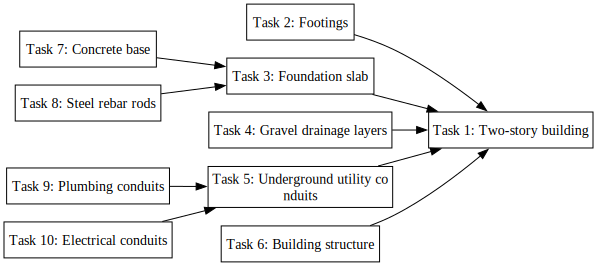

In [12]:
graph=display_graphviz('task9_graph.dot')
graph
